In [3]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# To Do

- Do I need to standardize other than regression?
- Make probabilities for every row and backtest
- Combine features?
    - age_difference
- Add features
    - Winning %
    - Strength of schedule
    - Endurance score
    - Pace
    - Momentum (substitute win streak)

# Potential Features

- **Win-Loss Record**: The number of wins, losses, and possibly draws in a fighter's career.
- **Opponent’s Win-Loss Record**: The record of the current opponent, providing context for the difficulty of the matchup.
- **Knockout (KO) and Submission Wins**: The number of wins by knockout and submission, providing insight into the fighter's preferred and most successful methods of victory.
- **Recent Win Rate** (`recent_win_rate`): This feature captures the fighter's recent form, providing insight into their current performance level.
- **Win Streak** (`win_streak`): A fighter on a win streak may have momentum and confidence, which can be a psychological advantage.
- **Fight Activity**
- **Number of Fights/Experience**
- **Fighting Style**: Whether the fighter is more of a striker, grappler, or mixed.
- **Fighter's Age**: The age of the fighter, as younger or older fighters may have different performance patterns.
- **Age Difference** (`age_difference`): Age can significantly impact stamina, strength, and experience, making this a crucial feature.
- **Height Difference** (`height_difference`): Height can influence a fighter's reach and striking ability, which are critical factors in a fight.
- **Reach Difference** (`reach_difference`): A longer reach can provide a strategic advantage in striking, making this an important feature.
- **Striking Accuracy**: The percentage of strikes landed out of attempted strikes, indicating striking effectiveness.
- **Takedown Accuracy**: The percentage of successful takedowns, indicating grappling effectiveness.
- **Defense**: Statistics like significant strikes absorbed per minute and takedown defense, which show a fighter's ability to avoid damage and resist takedowns.

In [4]:
!rm -rf data-bak && mv data data-bak && mkdir data
!cp ../Scrapers/data/fighter_info.csv data/
!cp ../Scrapers/data/event_data_sherdog.csv data/
!cp ../Scrapers/data/github/master.csv data/
!cp -R ../Scrapers/data/fighters data/

In [5]:
# Remove all fights before 2012

df = pd.read_csv('data/event_data_sherdog.csv')
df['event date'] = pd.to_datetime(df['event date'])
df = df[df['event date'] >= '2012-01-01']
df.to_csv('data/event_data_sherdog.csv', index=False)

In [6]:
# Remove all DQs, No Contests, and Draws

df = pd.read_csv('data/event_data_sherdog.csv')
print(f"Number of rows before filtering: {len(df)}")
df = df[~df['winning method'].str.contains('Disqualification|No contest|Draw', case=False)]
print(f"Number of rows after filtering: {len(df)}")
df.to_csv('data/event_data_sherdog.csv', index=False)

Number of rows before filtering: 5263
Number of rows after filtering: 5134


In [7]:
# Remove special characters from winning fighter column

df = pd.read_csv('data/event_data_sherdog.csv')
def clean_name(name):
    return re.sub(r'[^a-zA-Z\s]', '', name).strip()
df['winning fighter'] = df['winning fighter'].apply(clean_name)
df['fighter 1'] = df['fighter 1'].apply(clean_name)
df['fighter 2'] = df['fighter 2'].apply(clean_name)
df.to_csv('data/event_data_sherdog.csv', index=False)

In [8]:
# Randomly switch 50% of fighter 1 to fighter 2 to balance dataset

df = pd.read_csv('data/event_data_sherdog.csv')

# Create the target variable: 1 if Fighter 1 wins, else 0
df['target'] = (df['winning fighter'] == df['fighter 1']).astype(int)

# Randomly select half of the rows to swap
rows_to_swap = df.sample(frac=0.5, random_state=42).index

# Swap Fighter 1 and Fighter 2 stats in the selected rows
swap_columns = [
    ('fighter1_age_on_fight_night', 'fighter2_age_on_fight_night'),
    ('fighter 1', 'fighter 2'),
    ('fighter1_current_win_streak', 'fighter2_current_win_streak'),
    ('fighter1_recent_win_rate_7fights', 'fighter2_recent_win_rate_7fights'),
    ('fighter1_recent_win_rate_5fights', 'fighter2_recent_win_rate_5fights'),
    ('fighter1_recent_win_rate_3fights', 'fighter2_recent_win_rate_3fights'),
    ('fighter1_current_layoff', 'fighter2_current_layoff'),
    ('fighter1_total_wins', 'fighter2_total_wins'),
    ('fighter1_total_losses', 'fighter2_total_losses'),
    ('fighter1_height_in_inches', 'fighter2_height_in_inches')
]

for col1, col2 in swap_columns:
    df.loc[rows_to_swap, [col1, col2]] = df.loc[rows_to_swap, [col2, col1]].values

# Swap the target variable
df.loc[rows_to_swap, 'target'] = 1 - df.loc[rows_to_swap, 'target']

# Save the updated dataset
df.to_csv('data/event_data_sherdog.csv', index=False)


In [ ]:
# Calculate age difference

# df['age_difference'] = df['fighter1_age_on_fight_night'] - df['fighter2_age_on_fight_night']

In [9]:
# Create upcoming fights to predict later on

df_events = pd.read_csv('data/event_data_sherdog.csv')
df_fighters = pd.read_csv('data/fighter_info.csv')

# Define the list of upcoming fights
upcoming_fighters = [
    ('gilbert burns', 'sean brady'),
    ('steve garcia', 'kyle nelson'),
    ('matt schnell', 'alessandro costa'),
    ('trevor peek', 'yanal ashmoz'),
    ('isaac dulgarian', 'brendon marotte')
]

# Function to calculate fighter age on fight night using current date
def calculate_age(birthdate):
    birthdate = datetime.strptime(birthdate, '%b %d, %Y')
    today = datetime.today()
    age = (today - birthdate).days // 365  # Age in years without decimals
    return age

# Function to parse event date
def parse_event_date(date_string):
    return datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')

# Function to get the most recent fight stats for a given fighter from the event dataset
def get_most_recent_fight_stats(fighter_name, df):
    fighter_fights = df[(df['fighter 1'].str.lower() == fighter_name) | 
                        (df['fighter 2'].str.lower() == fighter_name)]
    
    if fighter_fights.empty:
        return None
    
    most_recent_fight = fighter_fights.sort_values(by='event date', ascending=False).iloc[0]
    return most_recent_fight

# Prepare data for upcoming fights
upcoming_fight_data = []

for fighter1, fighter2 in upcoming_fighters:
    # Normalize fighter names
    fighter1 = fighter1.lower()
    fighter2 = fighter2.lower()
    
    # Get fighter details from fighter_info.csv
    fighter1_info = df_fighters[df_fighters['fighter'].str.lower() == fighter1]
    fighter2_info = df_fighters[df_fighters['fighter'].str.lower() == fighter2]
    
    if fighter1_info.empty or fighter2_info.empty:
        print(f"Missing data for {fighter1} or {fighter2}")
        continue
    
    # Calculate fighter age on fight night
    fighter1_age = calculate_age(fighter1_info.iloc[0]['birth date'])
    fighter2_age = calculate_age(fighter2_info.iloc[0]['birth date'])
    
    # Get fighter height in inches
    fighter1_height = fighter1_info.iloc[0]['height_in_inches']
    fighter2_height = fighter2_info.iloc[0]['height_in_inches']
    
    # Get most recent fight stats for current win streak and layoff
    fighter1_recent_fight = get_most_recent_fight_stats(fighter1, df_events)
    fighter2_recent_fight = get_most_recent_fight_stats(fighter2, df_events)
    
    if fighter1_recent_fight is None or fighter2_recent_fight is None:
        print(f"Skipping fight: {fighter1} vs {fighter2} due to missing recent fight data.")
        continue
    
    fighter1_win_streak = fighter1_recent_fight['fighter1_current_win_streak'] if fighter1_recent_fight['fighter 1'].lower() == fighter1 else fighter1_recent_fight['fighter2_current_win_streak']
    fighter2_win_streak = fighter2_recent_fight['fighter1_current_win_streak'] if fighter2_recent_fight['fighter 1'].lower() == fighter2 else fighter2_recent_fight['fighter2_current_win_streak']
    
    # Calculate layoff (time since last fight)
    today = datetime.today()
    fighter1_layoff = (today - parse_event_date(fighter1_recent_fight['event date'])).days
    fighter2_layoff = (today - parse_event_date(fighter2_recent_fight['event date'])).days
    
    # Create a new row with all data
    new_row = {
        'fighter1_age_on_fight_night': fighter1_age,
        'fighter2_age_on_fight_night': fighter2_age,
        'fighter1_height_in_inches': fighter1_height,
        'fighter2_height_in_inches': fighter2_height,
        'fighter1_current_win_streak': fighter1_win_streak,
        'fighter2_current_win_streak': fighter2_win_streak,
        'fighter1_current_layoff': fighter1_layoff,
        'fighter2_current_layoff': fighter2_layoff,
        'fighter 1': fighter1.title(),
        'fighter 2': fighter2.title()
    }
    
    upcoming_fight_data.append(new_row)

# Convert the list of dictionaries into a DataFrame
upcoming_fights_df = pd.DataFrame(upcoming_fight_data)
upcoming_fights_df.to_csv('data/upcoming_fights.csv')

In [10]:
# Function to convert probabilities to american odds

def probability_to_american_odds(prob):
    if prob >= 0.5:
        return round(-prob / (1 - prob) * 100)
    else:
        return f"+{round((1 - prob) / prob * 100)}"

In [11]:
!open data/event_data_sherdog.csv
!open data/upcoming_fights.csv

---

<!-- <h1 style="text-align: center; color: purple;">Logistic Regression</h1> -->
<h1 style="font-size: 36px; color: purple;">Logistic Regression</h1>

##### X: 
- fighter1_age_on_fight_night
- fighter2_age_on_fight_night
- fighter1_height_in_inches
- fighter2_height_in_inches
- fighter1_current_win_streak
- fighter2_current_win_streak
- fighter1_current_layoff 
- fighter2_current_layoff

##### y: 
- winning fighter (target)

Accuracy: 74.68%

Coefficients:
fighter1_current_layoff       -1.053760
fighter2_current_win_streak   -0.693843
fighter1_height_in_inches     -0.057041
fighter1_age_on_fight_night   -0.019636
fighter2_age_on_fight_night    0.002499
fighter2_height_in_inches      0.074589
fighter1_current_win_streak    0.618119
fighter2_current_layoff        1.015342
dtype: float64 

Intercept: [-0.00880768]

R-squared (Training Set): 0.7520097442143727
R-squared (Test Set): 0.7468354430379747

Confusion Matrix:
[[377 137]
 [123 390]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       514
           1       0.74      0.76      0.75       513

    accuracy                           0.75      1027
   macro avg       0.75      0.75      0.75      1027
weighted avg       0.75      0.75      0.75      1027



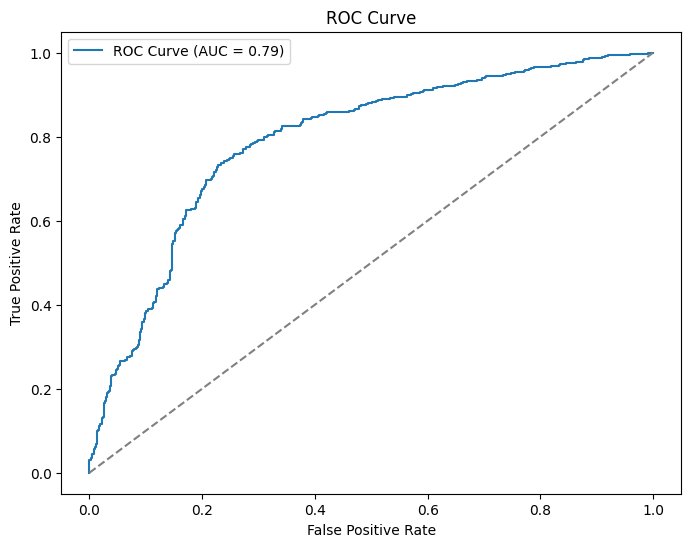

In [12]:
# Logistic Regression

df = pd.read_csv('data/event_data_sherdog.csv')

# Drop row with missing fighter height
df = df.dropna(subset=['fighter2_height_in_inches'])

# Select features to include in the model
features = [
    'fighter1_age_on_fight_night',
    'fighter2_age_on_fight_night',
    'fighter1_height_in_inches',
    'fighter2_height_in_inches',
    'fighter1_current_win_streak',
    'fighter2_current_win_streak',
    'fighter1_current_layoff',
    'fighter2_current_layoff'
]
X = df[features]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
coefficients = pd.Series(model.coef_[0], index=features)
coefficients = coefficients.sort_values()
intercept = model.intercept_
r_squared_train = model.score(X_train, y_train)
r_squared_test = model.score(X_test, y_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: {:.2f}%\n".format(accuracy * 100))
print("Coefficients:")
print(coefficients, "\n")
print(f'Intercept: {intercept}\n')
print(f'R-squared (Training Set): {r_squared_train}')
print(f'R-squared (Test Set): {r_squared_test}')
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

# Get the predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# # Predict probabilities for the entire dataset
# X_all = scaler.transform(X)
# df['fighter1_win_probability'] = model.predict_proba(X_all)[:, 1]

# # Display the updated DataFrame with probabilities
# print(df[['fighter 1', 'fighter 2', 'fighter1_win_probability']].head())

# # Optionally, save the DataFrame to a new CSV file
# df.to_csv('data/event_data_sherdog_with_probabilities.csv', index=False)
# !open data/event_data_sherdog_with_probabilities.csv

In [13]:
# Predict Upcoming Fights Probabilities

upcoming_fights_df = pd.read_csv('data/upcoming_fights.csv')

# Ensure columns match the training set
X_upcoming = upcoming_fights_df[features]

# Standardize the features
X_upcoming_scaled = scaler.transform(X_upcoming)

# Predict the probabilities for the upcoming fights
upcoming_fights_df['fighter1_win_probability'] = model.predict_proba(X_upcoming_scaled)[:, 1]

# Display the predicted probabilities for the upcoming fights
print(upcoming_fights_df[['fighter 1', 'fighter 2', 'fighter1_win_probability']])

# Convert the win probabilities to American odds
upcoming_fights_df['fighter1_american_odds'] = upcoming_fights_df['fighter1_win_probability'].apply(probability_to_american_odds)

# Display the predicted probabilities and American odds for the upcoming fights
print('\n')
print(upcoming_fights_df[['fighter 1', 'fighter 2', 'fighter1_american_odds']])

         fighter 1         fighter 2  fighter1_win_probability
0    Gilbert Burns        Sean Brady                  0.408098
1     Steve Garcia       Kyle Nelson                  0.596747
2     Matt Schnell  Alessandro Costa                  0.367607
3      Trevor Peek      Yanal Ashmoz                  0.564800
4  Isaac Dulgarian   Brendon Marotte                  0.541816


         fighter 1         fighter 2 fighter1_american_odds
0    Gilbert Burns        Sean Brady                   +145
1     Steve Garcia       Kyle Nelson                   -148
2     Matt Schnell  Alessandro Costa                   +172
3      Trevor Peek      Yanal Ashmoz                   -130
4  Isaac Dulgarian   Brendon Marotte                   -118


---

<h1 style="font-size: 36px; color: purple;">Random Forest</h1>

##### X: 
- fighter1_age_on_fight_night
- fighter2_age_on_fight_night
- fighter1_height_in_inches
- fighter2_height_in_inches
- fighter1_current_win_streak
- fighter2_current_win_streak
- fighter1_current_layoff 
- fighter2_current_layoff

##### y: 
- winning fighter (target)

In [14]:
# Random Forest

df = pd.read_csv('data/event_data_sherdog.csv')

# Drop row with missing fighter height
df = df.dropna(subset=['fighter2_height_in_inches'])

# Select features to include in the model
features = [
    'fighter1_age_on_fight_night',
    'fighter2_age_on_fight_night',
    'fighter1_height_in_inches',
    'fighter2_height_in_inches',
    'fighter1_current_win_streak',
    'fighter2_current_win_streak'
]
X = df[features]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize Random Forest model
model = RandomForestClassifier(random_state=0)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Random Forest Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Random Forest Model Results:
Accuracy: 60.56%

Confusion Matrix:
 [[315 199]
 [206 307]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.61      0.61       514
           1       0.61      0.60      0.60       513

    accuracy                           0.61      1027
   macro avg       0.61      0.61      0.61      1027
weighted avg       0.61      0.61      0.61      1027



In [15]:
# Predict Upcoming Fights Probabilities

upcoming_fights_df = pd.read_csv('data/upcoming_fights.csv')

# Ensure columns match the training set
X_upcoming = upcoming_fights_df[features]

# Standardize the features
X_upcoming_scaled = scaler.transform(X_upcoming)

# Predict the probabilities for the upcoming fights
upcoming_fights_df['fighter1_win_probability'] = model.predict_proba(X_upcoming_scaled)[:, 1]

# Display the predicted probabilities for the upcoming fights
print(upcoming_fights_df[['fighter 1', 'fighter 2', 'fighter1_win_probability']])

# Convert the win probabilities to American odds
upcoming_fights_df['fighter1_american_odds'] = upcoming_fights_df['fighter1_win_probability'].apply(probability_to_american_odds)

# Display the predicted probabilities and American odds for the upcoming fights
print('\n')
print(upcoming_fights_df[['fighter 1', 'fighter 2', 'fighter1_american_odds']])

         fighter 1         fighter 2  fighter1_win_probability
0    Gilbert Burns        Sean Brady                     0.070
1     Steve Garcia       Kyle Nelson                     0.470
2     Matt Schnell  Alessandro Costa                     0.240
3      Trevor Peek      Yanal Ashmoz                     0.440
4  Isaac Dulgarian   Brendon Marotte                     0.555


         fighter 1         fighter 2 fighter1_american_odds
0    Gilbert Burns        Sean Brady                  +1329
1     Steve Garcia       Kyle Nelson                   +113
2     Matt Schnell  Alessandro Costa                   +317
3      Trevor Peek      Yanal Ashmoz                   +127
4  Isaac Dulgarian   Brendon Marotte                   -125


---

<h1 style="font-size: 36px; color: purple;">XGBoost</h1>

##### X: 
- fighter1_age_on_fight_night
- fighter2_age_on_fight_night
- fighter1_height_in_inches
- fighter2_height_in_inches
- fighter1_current_win_streak
- fighter2_current_win_streak
- fighter1_current_layoff 
- fighter2_current_layoff

##### y: 
- winning fighter (target)

Accuracy: 73.32%


Confusion Matrix:
[[379 135]
 [139 374]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       514
           1       0.73      0.73      0.73       513

    accuracy                           0.73      1027
   macro avg       0.73      0.73      0.73      1027
weighted avg       0.73      0.73      0.73      1027



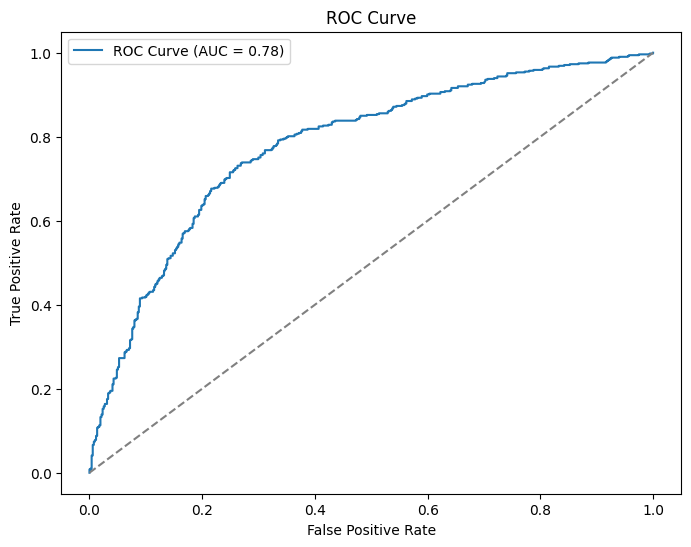

In [16]:
# XGBoost

df = pd.read_csv('data/event_data_sherdog.csv')

# Drop rows with missing fighter height
df = df.dropna(subset=['fighter2_height_in_inches'])

# Select features to include in the model
features = [
    'fighter1_age_on_fight_night',
    'fighter2_age_on_fight_night',
    'fighter1_height_in_inches',
    'fighter2_height_in_inches',
    'fighter1_current_win_streak',
    'fighter2_current_win_streak',
    'fighter1_current_layoff',
    'fighter2_current_layoff'
]
X = df[features]
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the XGBoost model
model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%\n".format(accuracy * 100))
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

# Get the predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [17]:
# Predict Upcoming Fights Probabilities

upcoming_fights_df = pd.read_csv('data/upcoming_fights.csv')

# Ensure columns match the training set
X_upcoming = upcoming_fights_df[features]

# Standardize the features
X_upcoming_scaled = scaler.transform(X_upcoming)

# Predict the probabilities for the upcoming fights
upcoming_fights_df['fighter1_win_probability'] = model.predict_proba(X_upcoming_scaled)[:, 1]

# Display the predicted probabilities for the upcoming fights
print(upcoming_fights_df[['fighter 1', 'fighter 2', 'fighter1_win_probability']])

# Convert the win probabilities to American odds
upcoming_fights_df['fighter1_american_odds'] = upcoming_fights_df['fighter1_win_probability'].apply(probability_to_american_odds)

# Display the predicted probabilities and American odds for the upcoming fights
print('\n')
print(upcoming_fights_df[['fighter 1', 'fighter 2', 'fighter1_american_odds']])

         fighter 1         fighter 2  fighter1_win_probability
0    Gilbert Burns        Sean Brady                  0.244805
1     Steve Garcia       Kyle Nelson                  0.707968
2     Matt Schnell  Alessandro Costa                  0.208582
3      Trevor Peek      Yanal Ashmoz                  0.778685
4  Isaac Dulgarian   Brendon Marotte                  0.743971


         fighter 1         fighter 2 fighter1_american_odds
0    Gilbert Burns        Sean Brady                   +308
1     Steve Garcia       Kyle Nelson                   -242
2     Matt Schnell  Alessandro Costa                   +379
3      Trevor Peek      Yanal Ashmoz                   -352
4  Isaac Dulgarian   Brendon Marotte                   -291


---

---